In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors
import matplotlib
import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.colors as col
import matplotlib.cm as cm
from ase.io import read
import copy
import matplotlib.patches as patches

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy
from timeit import default_timer as de_time
from pymcaspec import specfile
import numbers

#plt.rcParams['text.usetex'] = True
mpl.rc('lines', markersize=3)
colors = [f'C{i}' for i in range(10)]
font = {'size' : 7}
matplotlib.rc('font', **font)

In [2]:
# Helper functions
def mybin(x,y,yerr, binsize):
    new_x = []
    new_y = []
    new_yerr = []
    index = len(x)
    for i in range(0,index, binsize): #n is index, i is value      
        new_x.append(np.mean(x[i:i+binsize]))
        new_y.append(np.mean(y[i:i+binsize]))
        new_yerr.append(np.sqrt(np.mean(yerr[i:i+binsize]**2)))  
    new_x = np.array(new_x)
    new_y = np.array(new_y)
    new_yerr = np.array(new_yerr)
    
    return new_x, new_y, new_yerr

def rixsDataReader(data_folder, scan, spectrum_name='SPC', xshift = 0, interp=False, x_ref=None, scale = 1, norm=False, 
                   monitor_name='Mirror current / 1e6'): 
    f = specfile(data_folder)
    s = f[scan]
    x = -s['Energy (eV)'][::-1]
    y = s[spectrum_name][::-1]
    
    x = x + xshift
    yerr = np.sqrt(y)

    if interp and isinstance(x_ref, (list, np.ndarray)):
        y = np.interp(x_ref,x,y)
        yerr = np.sqrt(y)
        x = x_ref
    
    if norm:
        norm_factor = s[monitor_name][::-1]
        # Multiply by average of normalization factor, and divide by count time to get approx. cps
        norm_average = np.average(s['Mirror current / 1e6'][::-1])/5400
        y = norm_average*y / norm_factor
        yerr = norm_average*yerr / norm_factor

    y = y * scale
    yerr = yerr * scale
    return x, y, yerr

def plot2d(ax, x, y, Int, colormap='jet',shading='nearest'):
    x = np.array(x)
    y = np.array(y)
    if len(x) != np.shape(Int)[0]:
        print("wrong dimension for x, should be the same as the 1st dimension of Int\n")
    elif len(y) != np.shape(Int)[1]:
        print("wrong dimension for y, should be the same as the 2nd dimension of Int\n")
    else:
        x_mesh,y_mesh = np.meshgrid(x,y)
        im = ax.pcolormesh(x_mesh,y_mesh,np.fliplr(np.rot90(Int, k=-1)),
                           shading=shading, #'nearest', 'gouraud'
                           cmap=colormap, 
                          )
        return im

def myrixs2d(data_folder, scans, ax, x_axis, spectrum_name='SPC', colormap='jet', xshift=0, scale=1, norm=False, 
             monitor_name='Mirror current / 1e6', binsize=1, shading='nearest'):
    
    Int = []
    if isinstance(xshift, (list, np.ndarray)):
        xshift = np.array(xshift)
    elif isinstance(xshift, numbers.Number):
        xshift = np.ones(len(scans)) * xshift
    else:
        print('wrong input type for xshift, must be a number, a list, or a numpy array')
    
    if isinstance(scale, (list, np.ndarray)):
        scale = np.array(scale)
    elif isinstance(scale, numbers.Number):
        scale = np.ones(len(scans)) * scale
    else:
        print('wrong input type for xshift, must be a number, a list, or a numpy array')
        
        
    for i in range(len(scans)):
        scan = scans[i]
        if i == 0:
            x,y, yerr = rixsDataReader(data_folder=data_folder, scan=scan, spectrum_name=spectrum_name, xshift=xshift[i], 
                                       interp=False, scale=scale[i], norm=norm, monitor_name=monitor_name,)
            x_ref = x
            x_binned,y_binned,yerr_binned = mybin(x,y,yerr, binsize)
        else:
            x,y, yerr = rixsDataReader(data_folder=data_folder, scan=scan, spectrum_name=spectrum_name, xshift=xshift[i], 
                                       interp=True, x_ref = x_ref, scale=scale[i], norm=norm, monitor_name=monitor_name,)
            x_binned,y_binned,yerr_binned = mybin(x,y,yerr, binsize)
        Int.append(y_binned)
    Int = np.concatenate(Int)
    Int = Int.reshape(x_axis.size, x_binned.size)
    im = plot2d(ax=ax, x=x_axis, y=x_binned, Int=Int, colormap=colormap, shading=shading)
        
    return im

def absorptionFactor(th, tth, thickness, penetrationDepth):
    th_i = np.deg2rad(th)
    th_o = np.deg2rad(tth - th)
    A = np.sin(th_o) / (np.sin(th_i)+np.sin(th_o))
    return A * (1 - np.exp(-thickness/A/penetrationDepth/np.sin(th_i)))




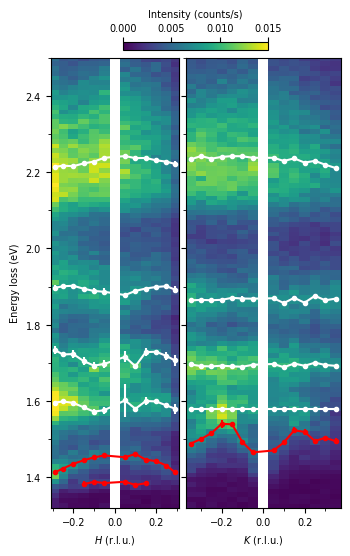

In [3]:
# Make the figure and subplots
fig = plt.figure(figsize=((3+3/8), 5.5))

hh = 0.46
ax2 = fig.add_axes((.53, .08, hh, 0.98))
ax1 = fig.add_axes((.13, .08, hh*0.31/0.375, 0.98))


# Load the data
# H0L
fh = specfile('./Online_analysis_20220914_CrSBr_5_dispersion_00_dir.spec')
datafolderh = './Online_analysis_20220914_CrSBr_5_dispersion_00_dir.spec'

scanlisth = range(20, 31+1)

# Sort the scanlist
hlist = []
for i, key in enumerate(scanlisth):
    s = fh[key]
    H = s.get_baseline('H')
    hlist.append(H)
sortlist = sorted(zip(hlist, scanlisth) )
scanlisth = [tt[1] for tt in sortlist]
hlist = [tt[0] for tt in sortlist]

# 0KL
fk = specfile('./Online_analysis_20220915_CrSBr_5_K_dispersion_00_dir.spec')
data_folderk = './Online_analysis_20220915_CrSBr_5_K_dispersion_00_dir.spec'

scanlistk = range(59, 72+1)
# Sort the scanlist
klist = []
for i, key in enumerate(scanlistk):
    s = fk[key]
    K = s.get_baseline('K')
    klist.append(K)
sortlist = sorted(zip(klist, scanlistk) )
scanlistk = [tt[1] for tt in sortlist]
klist = [tt[0] for tt in sortlist]

# Get the fitted peak positions
# H0L
hdat = np.genfromtxt('./hdisp.txt')

# 0KL
kdat = np.genfromtxt('./kdisp.txt')


# Plot the map with the fitted peak positions

#################
# H0L
# Plot one side of the dispersion
scans = np.asarray(scanlisth[:6])
Ks = np.asarray(hlist[:6])
ths = np.array([9.4125, 23.8475, 36.9375, 47.9, 57.8175, 67.185,])
tth = 149
offlist = hdat[:,2]
xshifts = offlist[:6]
scales = absorptionFactor(th=ths, tth=tth, thickness=10e7, penetrationDepth=100)
scales = 1

norm = True
monitor_name = 'Mirror current / 1e6'

binsize = 4
shading = 'nearest'

im1 = myrixs2d(datafolderh, scans=scans, ax=ax1, x_axis=Ks[0:6], spectrum_name='SPC', colormap='viridis', 
               xshift=xshifts, scale=1/scales, norm=norm, monitor_name=monitor_name, binsize=binsize, shading=shading)

# Plot the other side of the dispersion
scans = np.asarray(scanlisth[6:])
Ks = np.asarray(hlist[6:])
ths = np.array([85.435, 94.8025, 104.7175, 115.68, 128.77, 143.2075,])
xshifts = offlist[6:]
scales = absorptionFactor(th=ths, tth=tth, thickness=10e7, penetrationDepth=100)
scales = 1

norm = True
monitor_name = 'Mirror current / 1e6'

shading = 'nearest'

im2 = myrixs2d(datafolderh, scans=scans, ax=ax1, x_axis=Ks[0:6], spectrum_name='SPC', colormap='viridis', 
               xshift=xshifts, scale=1/scales, norm=norm, monitor_name=monitor_name, binsize=binsize, shading=shading)


######################################################
# Settings for the map
#cmax = 0.023
cmax = 0.015
ymin = 1.32
ymax = 2.5
im1.set_clim(0, cmax)
im2.set_clim(0, cmax)

ax1.set_xlim(-0.31,0.31)
ax1.set_ylim(ymin, ymax)
ax1.set_xlabel("$H$ (r.l.u.)")
ax1.set_ylabel("Energy loss (eV)")


# Plot the peak positions
ax1.errorbar(hlist, hdat[:,3], hdat[:,4], marker='o', color='r' )
ax1.errorbar(hlist[3:9], hdat[3:9,9], hdat[3:9,10], marker='o', color='r' )
ax1.errorbar(hlist, hdat[:,15], hdat[:,16], marker='o', color='w' )
ax1.errorbar(hlist, hdat[:,21], hdat[:,22], marker='o', color='w' )
ax1.errorbar(hlist, hdat[:,27], hdat[:,28], marker='o', color='w' )
ax1.errorbar(hlist, hdat[:,33], hdat[:,34], marker='o', color='w' )





#################
# 0KL

# Plot one side of the dispersion
scans = np.asarray(scanlistk[:7])
Ks = np.asarray(klist[:7])
ths = np.array([20.11, 30.5875, 39.42, 47.355, 54.7375, 61.7775, 68.615, 82.095, 88.93, 95.9725, 103.355, 111.29, 120.122, 130.6])
tth = 149
offlist = kdat[:,2]
xshifts = offlist[:7]
scales = absorptionFactor(th=ths, tth=tth, thickness=10e7, penetrationDepth=100)
scales = 1

norm = True
monitor_name = 'Mirror current / 1e6'
shading = 'nearest'

im3 = myrixs2d(data_folderk, scans=scans, ax=ax2, x_axis=Ks[0:7], spectrum_name='SPC', colormap='viridis', 
               xshift=xshifts, scale=1/scales, norm=norm, monitor_name=monitor_name, binsize=binsize, shading=shading)

# Plot the other side of the dispersion
scans = np.asarray(scanlistk[7:])
Ks = np.asarray(klist[7:])
ths = np.array([ 82.095, 88.93, 95.9725, 103.355, 111.29, 120.122, 130.6])
xshifts = offlist[7:]
scales = absorptionFactor(th=ths, tth=tth, thickness=10e7, penetrationDepth=100)
scales = 1

norm = True
monitor_name = 'Mirror current / 1e6'
shading = 'nearest'

im4 = myrixs2d(data_folderk, scans=scans, ax=ax2, x_axis=Ks[0:7], spectrum_name='SPC', colormap='viridis', 
               xshift=xshifts, scale=1/scales, norm=norm, monitor_name=monitor_name, binsize=binsize, shading=shading)


######################################################
# Settings for the map
im3.set_clim(0, cmax)
im4.set_clim(0, cmax)
cbar = plt.colorbar(im4, ax=[ax1, ax2], shrink=0.5, label='Intensity (counts/s)', location='top', pad=0.015)

ax2.set_xlim(-0.375,0.375)
ax2.set_ylim(ymin, ymax)
ax2.set_xlabel("$K$ (r.l.u.)")
#ax2.set_ylabel("Energy loss (eV)",fontsize=14)

# Plot the peak positions
ax2.errorbar(klist, kdat[:,3], kdat[:,4], marker='o', color='r' )
ax2.errorbar(klist, kdat[:,9], kdat[:,10], marker='o', color='w' )
ax2.errorbar(klist, kdat[:,15], kdat[:,16], marker='o', color='w' )
ax2.errorbar(klist, kdat[:,21], kdat[:,22], marker='o', color='w' )
ax2.errorbar(klist, kdat[:,27], kdat[:,28], marker='o', color='w' )

ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax2.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax2.tick_params(labelleft = False )


"""
from matplotlib.patches import Rectangle
rr = Rectangle((-0.28, 1.66), 0.56, 0.1, edgecolor='r', facecolor='None')
ax1.add_patch(rr)

r2 = Rectangle((-0.35, 1.65), 0.7, 0.1, edgecolor='r', facecolor='None')
ax2.add_patch(r2)
"""
plt.show()
